In [1]:
import os
import voc12.my_dataloader
from utility import image_util, util
from torch.utils.data import DataLoader
import torch
from misc import imutils
import importlib
import torch.nn.functional as F
import numpy as np
import importlib
import voc12.dataloader
import importlib
from tqdm import tqdm
from misc import indexing
from PIL import Image

In [2]:
crop_cam_weight_name = "../sess/voc_sess/resnet50_crop_cam"

trainval_list = "voc12/val.txt"
voc12_root = "../Dataset/VOC2012/"
cam_root = "../irn_result/cam/"
cam_scales = (1.0, 1.5, 0.5, 2.0)

device = "cuda:1"

In [3]:
model = getattr(importlib.import_module("net.resnet50_cam"), 'CAM')()
model.load_state_dict(torch.load(crop_cam_weight_name + '.pth'), strict=True)
model.eval()

model = model.to(device)

In [4]:
dataset = voc12.my_dataloader.VOC12_CropClassificationDatasetMSF(trainval_list, voc12_root = voc12_root,
                                                          cam_root = cam_root, scales=cam_scales)

100%|██████████| 2913/2913 [00:16<00:00, 174.67it/s]


In [7]:
data_loader = DataLoader(dataset, shuffle=False,num_workers=os.cpu_count(), pin_memory=False)


with torch.no_grad():

    pack = next(iter(data_loader))
    img_name = pack['name'][0]
    msf = pack['msf_img_list']
    org_size = pack['size']
    strided_org_size = imutils.get_strided_size(org_size, 4)

    org_cam = pack['cam'][0].cpu().numpy()
    org_high_res = pack['high_res'][0].cpu().numpy()
    crop_labels = pack['crop_labels']
    crop_boxes = pack['crop_boxes']
    crop_boxes = [tuple(int(t.item()) for t in crop_box) for crop_box in crop_boxes]
    
    strided_crop_boxes = image_util.resize_bbox_list(crop_boxes, org_size, strided_org_size)
    
    cam_list = []
    highres_cam_list = []

    key = torch.sum(torch.cat(crop_labels, dim=0), dim=0)
    key = torch.nonzero(key)[:, 0]
    for idx, msf_img in enumerate(msf):
        
        msf_img = msf[idx]
        label = crop_labels[idx][0]
        
        size = (crop_boxes[idx][3] - crop_boxes[idx][1], crop_boxes[idx][2] - crop_boxes[idx][0])
        
        strided_size = imutils.get_strided_size(size, 4)
        strided_up_size = imutils.get_strided_up_size(size, 16)
        
        valid_cat = torch.nonzero(label)[:, 0]
        
        outputs = [model(img[0].to(device)) for img in msf_img]
        
        strided_cam = torch.sum(torch.stack(
        [F.interpolate(torch.unsqueeze(o, 0), strided_size, mode='bilinear', align_corners=False)[0] for o
            in outputs]), 0)
        
        highres_cam = [F.interpolate(torch.unsqueeze(o, 1), strided_up_size,
                                    mode='bilinear', align_corners=False) for o in outputs]

        
        highres_cam = torch.sum(torch.stack(highres_cam, 0), 0)[:, 0, :size[0], :size[1]]
        
        highres_cam = highres_cam[valid_cat]
        highres_cam /= F.adaptive_max_pool2d(highres_cam, (1, 1)) + 1e-5
        
        strided_cam = strided_cam[valid_cat]
        strided_cam /= F.adaptive_max_pool2d(strided_cam, (1, 1)) + 1e-5
        
        strided_cam = strided_cam[0].cpu().numpy()
        highres_cam = highres_cam[0].cpu().numpy()

        strided_cam = image_util.crop_cam_to_org_cam(strided_cam, strided_crop_boxes[idx], strided_org_size)
        highres_cam = image_util.crop_cam_to_org_cam(highres_cam, crop_boxes[idx], org_size)
        
        cam_list.append(strided_cam)
        highres_cam_list.append(highres_cam)
    
    cam_stack = np.stack(cam_list)
    cam_stack = (cam_stack + org_cam) / 2
    
    highres_cam_stack = np.stack(highres_cam_list)
    highres_cam_stack = (highres_cam_stack + org_high_res) / 2
    
    cam_stack = torch.from_numpy(cam_stack)

/workspace/voc_cam/misc/imutils.py:177: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return ((orig_size[0]-1)//stride+1, (orig_size[1]-1)//stride+1)


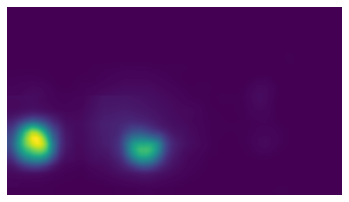

In [10]:
image_util.image_show(highres_cam_stack[1])